In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

In [3]:
class geometric_network():
    def __init__(self, network_type, size, **kwargs):
        ####################################
        ##### Geometric Network Object #####
        ####################################
        
        ### input -- network_type:
        ##                      2D_lattice: creates 2d lattice of given tiling-can be triangular, square, hexagonal
        #                                   --Additional Arguments--
        #                                     tiling = 3,4,6
        #                                     periodic = bool (connects the edge of the grid to the opposite edge)
        ##                      ring_lattice: creates a ring graph with each node degree 2
        #                                    --Additional Arguments--
        #                                     banded = bool
        #                                     band_length = gonna connect this many closest neigbors (skipping the 
        #                                                   adjacent nodes from both sides because they are already 
        #                                                   connected) from both sides to every node
        #                                     
        #                                     
        ### input -- size: network size, if 2D_lattice, then there will be size^2 many nodes.
        
        ### attribute -- geometric_network.N
        ### attribute -- geometric_network.M
        ### attribute -- geometric_network.graph
        ### attribute -- geometric_network.pos
        ### attribute -- geometric_network.A
        ### attribute -- geometric_network.text 
        
        ### function -- geometric_network.display(n_size, labels = Bool): take a sneakpeak on the networkx object
        ### function -- geometric_network.add_noise_to_geometric(noise_type, d2): add two types of noise
        #                                   either 'ER_like' or 'k_regular' of degree d2
        ### function -- geometric_network.run_excitation(Trials, p, T, seed, threshold): run 
        #                                   the excitation according to these parameters
        
        ### function -- geometric_network.spy_first_activation(first_activation_times): visualize the first
        #                                   activation, input of the functin is the 2nd output of run_excitation
        
        if network_type == '2D_lattice': 
            tiling = kwargs['tiling']
            per = kwargs['periodic']
            if tiling == 3: 
                self.graph = nx.triangular_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                

            elif tiling == 4: 
                self.graph = nx.grid_2d_graph(size, size, periodic = per)
                self.pos = dict( (n, n) for n in self.graph.nodes() )
                self.labels = dict( ((i, j), i * size + j) for i, j in self.graph.nodes() )
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                
            elif tiling == 6: 
                self.graph = nx.hexagonal_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
            
        elif network_type == 'ring_lattice':# TODO: banding for every node
            self.graph = nx.cycle_graph(size)
            theta = (2*np.pi)/size
            self.pos = dict((i,(np.sin(theta*i),np.cos(theta*i))) for i in range(size))
            self.M = len(self.graph.edges())
            self.N = len(self.graph.nodes())
            self.text = 'Ring Lattice'
            if kwargs['banded']:
                if kwargs['band_length'] >= int(self.N/2)-1: raise ValueError('Band length cannot exceed the half of the size of the network')
                if kwargs['band_length'] <2: raise ValueError('Band length should be a positive integer greater 1 since the closest neighbors are already connected')
                for u in range(self.N):
                    for i in range(2,kwargs['band_length']+1):# ranges from 2 to k+2 to avoid the closest node and start
                        ## banding from the second closest node
                        if u + i >= self.N: v = u + i - self.N
                        else: v = u + i
                        self.graph.add_edge(u, v)
                        if u - i < 0: v = self.N + u - i
                        else: v = u - i
                        self.graph.add_edge(u, v)
                self.text = self.text + ' w/ bandlength %d'%kwargs['band_length']
            else:self.text = self.text + ' w/ bandlength 0'
                        
        else: raise ValueError('network type can be a lattice or a ring')
            
        self.A = nx.adjacency_matrix(self.graph)## use .toarray() or .todense() attributes to call the sparse matrix
              
    def display(self, n_size = 15, labels = True):
        
        try: return(nx.draw(self.graph, pos = self.pos, node_size = n_size, with_labels = labels, font_weight = 'bold'))
        
        except: return(nx.draw(self.graph, with_labels = labels, font_weight = 'bold'))
        
    def add_noise_to_geometric(self, noise_type, d2):
        
        # this function adds nongeometric edges to the network that are long range. Depending on the 'noise_type'
        # the way we add these long range edges differ. If noise_type = ER_like, then there will be d2 many
        # non geometric edges ON AVARAGE for every node. When the noise_type = k_regular, every node will 
        # have exactly d2 many long range edges
        
        
        if noise_type == 'ER_like':   
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
                
            edges_built = 0
            
            while edges_built <= M/2:
                
                nodes_to_connect = [random.randint(0,self.N-1) for i in range(2)]
                
                if nodes_to_connect[0] == nodes_to_connect[1]: #no self-loops
                    edges_built = edges_built
                elif self.A.toarray()[nodes_to_connect[0]][nodes_to_connect[1]] == 1 or self.A.toarray()[nodes_to_connect[1]][nodes_to_connect[0]] == 1: # no existing loops
                    edges_built = edges_built
                else: 
                    self.graph.add_edge(nodes_to_connect[0],nodes_to_connect[1])
                    edges_built = edges_built + 1
            self.text = self.text + ' & ER-like noise w/ degree %d'%d2

                    
        elif noise_type == 'k_regular':
            
            self.text = self.text + ' & k-regular noise w/ degree %d'%d2
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
            flag_2 = True
            
            while flag_2:
                flag_2 = False
                #build stubs
                stubs = np.zeros(M)
                for i in range(self.N):
                    index = (i*d2) + np.arange(d2)
                    stubs[index[0]:index[-1]+1] = (i) * np.ones(d2)
                    
                #build undirected link list
                link_list = np.zeros((int(M/2),2))
                for m in range(int(M/2)):
                    flag_1 = True # turn on flag to enter while loop
                    count = 0
                    while flag_1:
                        flag_1 = False #turn off flag to exit while loop
                        rand = [random.randint(0,len(stubs)-1) for i in range(2)]
                        
                        node_A = int(stubs[rand[0]])
                        node_B = int(stubs[rand[1]])
                                                
                        if node_A == node_B: flag_1 = True
                        
                        for n in range(m):
                            if link_list[n,0] == node_A and link_list[n,1] == node_B:
                                flag_1 = True
                            if link_list[n,0] == node_B and link_list[n,1] == node_A:
                                flag_1 = True
                            if self.A.toarray()[node_A][node_B] == 1 or self.A.toarray()[node_B][node_A] == 1:
                                flag_1 = True
                                
                        count = count +1
                        
                        if count > M: flag_2 = True ; break
                            
                    #make link       
                    link_list[m,0] = node_A
                    link_list[m,1] = node_B
                    
                    #remove stubs from list
                    stubs = np.delete(stubs,[rand[0],rand[1]])
            
            #build network
            for m in range(int(M/2)):
                self.graph.add_edge(link_list[m,0],link_list[m,1])
            
        else: raise InputError('Noise type can only be ER_like or k_regular')
    
    def excitation(self, p, T, seed, threshold, ax = None, spy = False):
        
        n = self.N
        x_1 = sparse.lil_matrix(((n,T+1)), dtype = bool)
        activation_times = np.ones(n, dtype = int)*T
        excited_nodes = self.A[seed].nonzero()[1]
        deg = len(excited_nodes)
        
        ps = np.array([random.uniform(0,1) for i in range(deg)])
        pss = np.array([1-p for i in range(deg)])
        
        vals = ps > pss
        
        for i in range(deg): x_1[excited_nodes[i],0] = vals[i]
            
        t = 0
        all_nodes = set([k for k in range(n)])
        
        while t<T and len(excited_nodes)>0 and np.any(activation_times==T):
            x_old = x_1.toarray()[:,t]
            excited_nodes = np.nonzero(x_old)[0]         
            activation_times[excited_nodes] = np.minimum(activation_times[excited_nodes],np.array([t]*len(excited_nodes)))
            activation_times = activation_times.astype(np.int32)
            t+=1
            for j in list(all_nodes-set(excited_nodes)): 
                ids = np.nonzero(self.A[j])[1]
                rands = [random.uniform(0,1) for i in range(len(ids))]
                valid_neighbor_activations = []
                
                for y,e in enumerate(ids):
                    if x_old[e]*rands[y] > 1-p:
                        valid_neighbor_activations.append(x_old[e]*rands[y])
                        
                x_1[j,t] = bool(sum(valid_neighbor_activations)/len(valid_neighbor_activations) >= threshold)
                     
        if spy: ax.imshow(x_1.todense())
        
        if np.any(activation_times == T): 
            activation_retry = self.excitation(p, T, seed, threshold, ax = ax, spy = spy)
            return(activation_retry)
            
        else: return(activation_times)
    
    
    def run_excitation(self, Trials, p, T, seed, threshold, ax = None):
        
        n = self.N
        
        first_excitation_times = np.zeros((n,Trials))
        
        if ax is not None: 
            for i in range(Trials):
    
                first_exct = self.excitation(p = p, T = T, seed = seed, threshold = threshold, ax = ax[i], spy = True)
                first_excitation_times[:,i] = first_exct
                ax[i].set_title('Trial %d for %s'%(i+1, self.text), fontsize = 25)
                ax[i].set_xlabel('Time', fontsize = 35)
                ax[i].set_ylabel('Node ID',fontsize = 35)
                ax[i].set_xticks([5*t for t in range(int(T/5)+1)])
                ax[i].set_yticks([10*t for t in range(int(n/10))])
                ax[i].tick_params('both', which = 'major', labelsize = 15)
            plt.tight_layout()
            
        else:
            for i in range(Trials):
    
                first_exct = self.excitation(p = p, T = T, seed = seed, threshold = threshold)
                first_excitation_times[:,i] = first_exct
        
        return(first_excitation_times)
    

    def spy_first_activation(self, first_activation_times):
        
        fig,ax = plt.subplots(1,1,figsize = (10,8))
        
        pos = ax.imshow(first_activation_times, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',extent = [0.5,Trials+0.5,0,n])
        ax.set_title('First Activation Times for %s'%self.text, fontsize = 20)
        ax.set_xlabel('Trials', fontsize = 15)
        ax.set_ylabel('Node ID', fontsize = 15)
        ax.set_xticks([i for i in range(1,Trials+1)])
        
        fig.colorbar(pos, ax = ax)
        
    def average_over_trials(self, first_activation_times):return(np.mean(first_activation_times, axis = 1))
    
    def make_distance_matrix(self, p, T, threshold, Trials, spy_distance = False):
        n = self.N
        D = np.zeros((n,n))
        
        for i in range(n):
            D[i] = self.average_over_trials(self.run_excitation(Trials, p, T, i, threshold ))
        
        if spy_distance: 
            fig,ax = plt.subplots(1,1, figsize = (15*int(n/20),10*int(n/20)))
            pos = ax.imshow(D, origin = 'lower', interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,n-0.5,-0.5,n-0.5])
            ax.set_title('Distance Matrix for %s'%self.text, fontsize = 20)
            ax.set_ylabel('Excitation starting from node i', fontsize = 15)
            ax.set_xlabel('First time node j gets activated', fontsize = 15)
            ax.set_xticks([i*5 for i in range(int(n/5))])
            ax.set_yticks([i*5 for i in range(int(n/5))])

            fig.colorbar(pos, ax = ax)
        return(D)
    
    def compute_persistence(self, distances, spy = False):    
        rips_complex = gudhi.RipsComplex(distance_matrix = distances/np.max(distances), max_edge_length = 1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence(min_persistence = 0.0)
        if spy: 
            gudhi.plot_persistence_diagram(diag)
            #plt.savefig('/Users/bengieru/persistence.pdf')
        return(diag)
    
    def one_d_Delta(self, persistence):
        oned_holes = [(0,0)]
        for i in range(len(persistence)):
            if persistence[i][0] == 1:
                oned_holes.append(persistence[i][1])
        oned_holes = oned_holes
        oned_holes = np.array(oned_holes)
        persistence_life_times = oned_holes[:,1]-oned_holes[:,0]
        Delta = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[-2]
        return(Delta)

In [4]:
n = 20
G = geometric_network('ring_lattice', size = n, banded = True, band_length = 4)

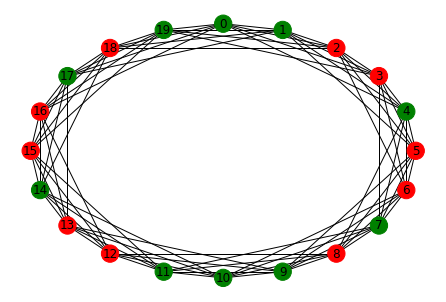

In [7]:
colors = ['green','green','red','red','green', 'red', 'red', 'green', 'red', 'green']
colors = colors+colors

nx.draw(G.graph, pos = G.pos, node_color = colors, with_labels = True)
#plt.savefig('/Users/bengieru/Desktop/Network_Dynamics/fig1.pdf')

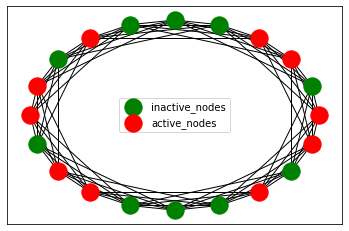

In [8]:
colors = ['green','green','red','red','green', 'red', 'red', 'green', 'red', 'green']
inactive = [0,1,4,7,9,10,11,14,17,19]
active = [2,3,5,6,8,12,13,15,16,18]
colors = colors+colors

nx.draw_networkx_nodes(G.graph, pos = G.pos, nodelist = inactive, node_color = 'green', label = 'inactive_nodes', with_labels = True)
nx.draw_networkx_nodes(G.graph, pos = G.pos, nodelist = active, node_color = 'red', label = 'active_nodes', with_labels = True)
nx.draw_networkx_edges(G.graph, pos = G.pos)
plt.legend()
#plt.savefig('/Users/bengieru/Desktop/Network_Dynamics/fig2.pdf')

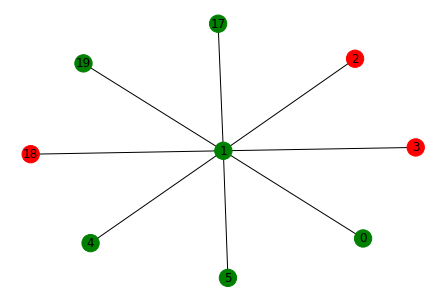

In [9]:
zooomed = nx.Graph()
colors = ['green', 'green','red','green','green','red','red','green','green']
zooomed.add_edges_from([(1,17),(1,18),(1,19),(1,0),(1,2),(1,3),(1,4),(1,5)])
nx.draw(zooomed, node_color = colors, with_labels = True)
#plt.savefig('/Users/bengieru/Desktop/Network_Dynamics/fig3.pdf')

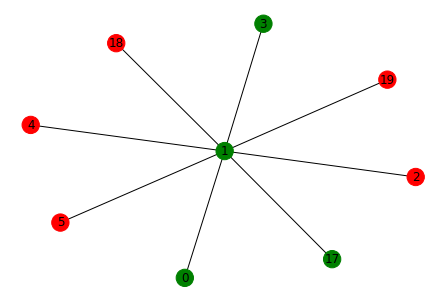

In [10]:
zooomed = nx.Graph()
colors = ['green', 'green','red','red','green','red','green','red','red']
zooomed.add_edges_from([(1,17),(1,18),(1,19),(1,0),(1,2),(1,3),(1,4),(1,5)])
nx.draw(zooomed, node_color = colors, with_labels = True)

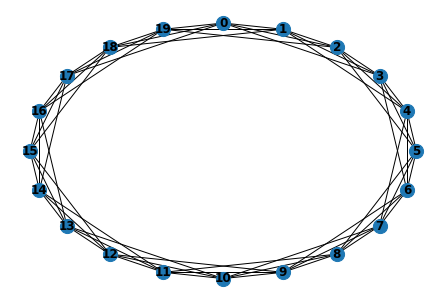

In [11]:
n = 20
G = geometric_network('ring_lattice', size = n, banded = True, band_length = 3)
G.display(n_size = 200)
#plt.savefig('/Users/bengieru/Desktop/Network_Dynamics/fig4.pdf')

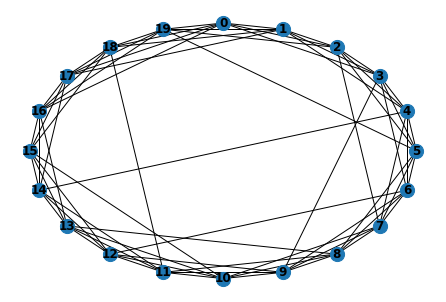

In [12]:
G.add_noise_to_geometric('k_regular', 1)
G.display(n_size = 200)
#plt.savefig('/Users/bengieru/Desktop/Network_Dynamics/fig5.pdf')

In [13]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

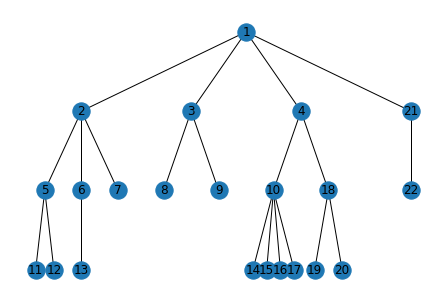

In [14]:
G=nx.Graph()
G.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
                  (5,11), (5,12), (6,13),(10,14),(10,15),(10,16),(10,17),(4,18),(18,19),(18,20),(1,21),(21,22)])
pos = hierarchy_pos(G,1)    
nx.draw(G, pos=pos, with_labels=True)
#plt.savefig('/Users/bengieru/Desktop/Network_Dynamics/fig6.pdf')

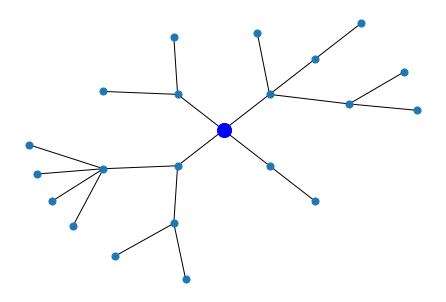

In [16]:
pos = hierarchy_pos(G, 1, width = 2*math.pi, xcenter=0)
new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
nx.draw(G, pos=new_pos, node_size = 50)
nx.draw_networkx_nodes(G, pos=new_pos, nodelist = [1], node_color = 'blue', node_size = 200)
plt.savefig('/Users/bengieru/Desktop/presentations/Network_Dynamics/circular_tree.pdf')